<a href="https://colab.research.google.com/github/DSK10/brain-tumor-classification-tensorflow/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification

## Clone the Github Repo to access the Dataset

In [ ]:
!git clone https://github.com/Ashish-Arya-CS/Coursera-Content.git

Cloning into 'Coursera-Content'...
remote: Enumerating objects: 3049, done.
remote: Counting objects: 100% (3049/3049), done.
remote: Compressing objects: 100% (3046/3046), done.
remote: Total 3049 (delta 1), reused 3043 (delta 0), pack-reused 0
Receiving objects: 100% (3049/3049), 79.25 MiB | 31.86 MiB/s, done.
Resolving deltas: 100% (1/1), done.


## Import necessary Libraries 

In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils    


## Creating Directories to store Cropped Images

In [ ]:
# Create Directory for Training Data
os.mkdir("/content/Crop-Brain-MRI")
os.mkdir("/content/Crop-Brain-MRI/glioma_tumor")
os.mkdir("/content/Crop-Brain-MRI/meningioma_tumor")
os.mkdir("/content/Crop-Brain-MRI/no_tumor")
os.mkdir("/content/Crop-Brain-MRI/pituitary_tumor")

In [ ]:
# Create Directory for Testing Data
os.mkdir("/content/Test-Data")
os.mkdir("/content/Test-Data/glioma_tumor")
os.mkdir("/content/Test-Data/meningioma_tumor")
os.mkdir("/content/Test-Data/no_tumor")
os.mkdir("/content/Test-Data/pituitary_tumor")

## Data Visualization

path_list =  ['/content/Coursera-Content/Brain-MRI/Training/meningioma_tumor/m1(44).jpg', '/content/Coursera-Content/Brain-MRI/Training/meningioma_tumor/m (122).jpg', '/content/Coursera-Content/Brain-MRI/Training/meningioma_tumor/m2 (144).jpg', '/content/Coursera-Content/Brain-MRI/Training/meningioma_tumor/m1(25).jpg', '/content/Coursera-Content/Brain-MRI/Training/meningioma_tumor/m1(143).jpg']
path_list =  ['/content/Coursera-Content/Brain-MRI/Training/pituitary_tumor/image(73).jpg', '/content/Coursera-Content/Brain-MRI/Training/pituitary_tumor/p (798).jpg', '/content/Coursera-Content/Brain-MRI/Training/pituitary_tumor/image(57).jpg', '/content/Coursera-Content/Brain-MRI/Training/pituitary_tumor/p (53).jpg', '/content/Coursera-Content/Brain-MRI/Training/pituitary_tumor/p (311).jpg']
path_list =  ['/content/Coursera-Content/Brain-MRI/Training/no_tumor/no (90).jpg', '/content/Coursera-Content/Brain-MRI/Training/no_tumor/no (215).jpg', '/content/Coursera-Content/Brain-MRI/Training/no_tum

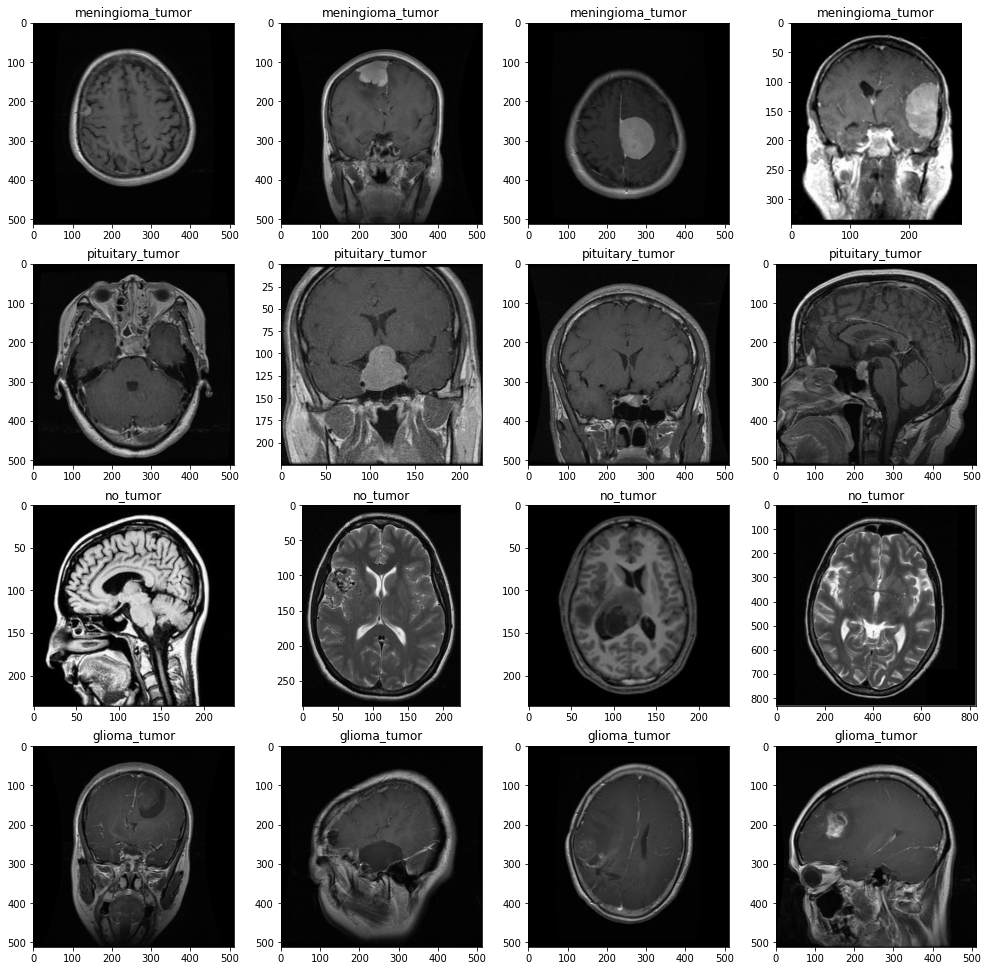

In [ ]:
train_dir = "/content/Coursera-Content/Brain-MRI/Training/"
test_dir = "/content/Coursera-Content/Brain-MRI/Testing/"
classes = os.listdir("/content/Coursera-Content/Brain-MRI/Training")
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir+c+'/'+x, os.listdir(train_dir+c)))

plt.figure(figsize=(17,17))
index=0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]
  print("path_list = ",path_list)

  for i in range(1,5):
    index += 1
    plt.subplot(4,4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

## Create a Function to Crop Images

In [ ]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


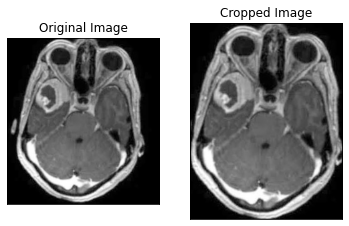

In [ ]:
example_img = cv2.imread("/content/Coursera-Content/Brain-MRI/Training/meningioma_tumor/image(61).jpg")
cropped_image = crop_image(example_img, plot=True)

## Saving The Cropped Images 

In [ ]:
# Crop the Training Images and Save it to the Directory we previously cretaed

glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
no_tumor = train_dir + "no_tumor"
pituitary = train_dir + "pituitary_tumor"

j=0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j=j+1

j=0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j=j+1

j=0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j=j+1


j=0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j=j+1

100%|██████████| 901/901 [00:05<00:00, 160.48it/s]


In [ ]:
# Crop the Testing Images and Save it to the Directory we previously cretaed


# Crop the Training Images and Save it to the Directory we previously cretaed

test_glioma = test_dir + "glioma_tumor"
test_meningioma = test_dir + "meningioma_tumor"
test_no_tumor = test_dir + "no_tumor"
test_pituitary = test_dir + "pituitary_tumor"

j=0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Data/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j=j+1

j=0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Data/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j=j+1

j=0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Data/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j=j+1


j=0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Data/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j=j+1

100%|██████████| 5/5 [00:00<00:00, 115.14it/s]


## Perform Data Augmentation and Prepare the Train, Validation and Test Dataset

In [ ]:
# Use Image Data Generator to perform this task.

datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI',
                                         target_size = (224,224),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')

valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI',
                                         target_size = (224,224),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/Test-Data/',
                                         target_size = (224,224),
                                         class_mode='categorical',)


Found 2613 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [ ]:
# View the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


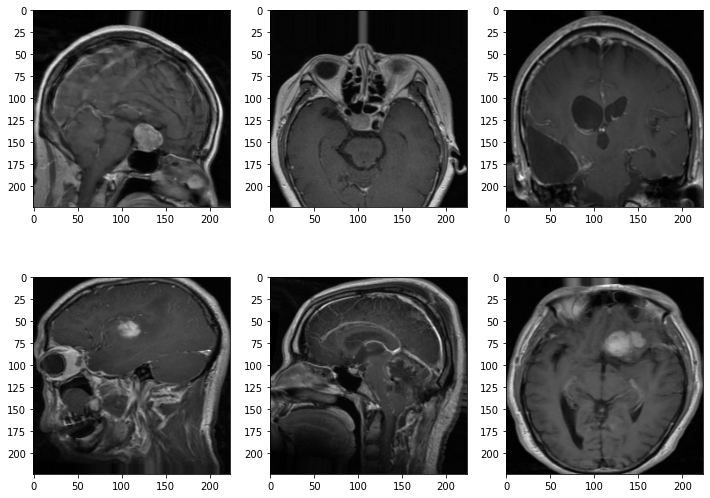

In [ ]:
# View the augmented data.
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12,9))
for i in range(6):
  plt.subplot(2,3,i+1)
  sample = array_to_img(sample_x[i])
  #plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

## Build and Compile the Model 

In [ ]:
# Build the Model
effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224,224,3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs = effnet.input, outputs=model)

model.summary()

27025408/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss="categorical_crossentropy", metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5", monitor="val_accuracy", save_best_only=True, mode="auto")
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

## Model Training and Model Evaluation

In [ ]:
# Train the model
history = model.fit(train_data, epochs=7, validation_data=valid_data, verbose=1, callbacks=[checkpoint,earlystop])

Epoch 1/7
82/82 [==============================] - 98s 670ms/step - loss: 0.4682 - accuracy: 0.8412 - val_loss: 1.7629 - val_accuracy: 0.6089


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/7
82/82 [==============================] - 50s 609ms/step - loss: 0.2311 - accuracy: 0.9208 - val_loss: 0.5389 - val_accuracy: 0.7991
Epoch 3/7
82/82 [==============================] - 51s 619ms/step - loss: 0.2117 - accuracy: 0.9311 - val_loss: 0.5270 - val_accuracy: 0.8129
Epoch 4/7
82/82 [==============================] - 51s 614ms/step - loss: 0.1372 - accuracy: 0.9506 - val_loss: 1.3705 - val_accuracy: 0.8006
Epoch 5/7
82/82 [==============================] - 50s 609ms/step - loss: 0.1287 - accuracy: 0.9575 - val_loss: 0.5457 - val_accuracy: 0.8359
Epoch 6/7
82/82 [==============================] - 50s 609ms/step - loss: 0.1092 - accuracy: 0.9629 - val_loss: 0.4390 - val_accuracy: 0.9049
Epoch 7/7
82/82 [==============================] - 50s 613ms/step - loss: 0.1066 - accuracy: 0.9690 - val_loss: 0.1344 - val_accuracy: 0.9601


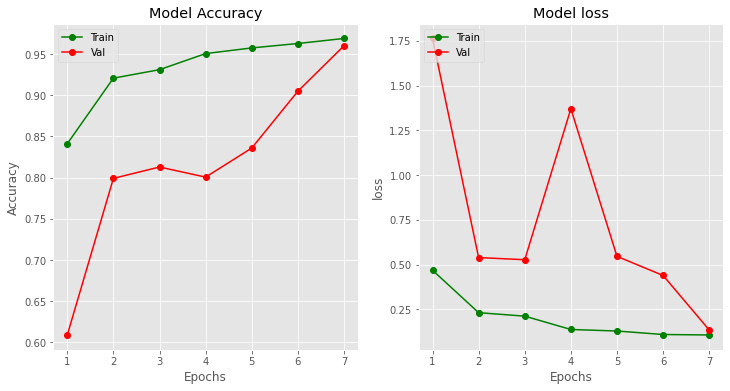

In [ ]:
# Plot the training curves
plt.style.use("ggplot")
plt.figure(figsize=(12,6))
epochs = range(1,8)
plt.subplot(1,2,1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Val"], loc="upper left")

plt.subplot(1,2,2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["Train","Val"], loc="upper left")

plt.show()

In [ ]:
# Evaluate the model on Test Set
model.evaluate(test_data)

1/1 [==============================] - 1s 932ms/step - loss: 0.1016 - accuracy: 0.9500


[0.10157517343759537, 0.949999988079071]

## Obtaining Predictions on Test Images

meningioma_tumor


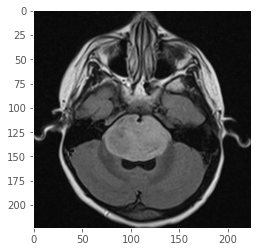

In [ ]:
# Obtain Predictions on Test Images
class_dict = {0:"glioma_tumor",1:"meningioma_tumor",2:"no_tumor",3:"pituitary_tumor"}

test_img1 = cv2.imread("/content/Test-Data/glioma_tumor/2.jpg")
plt.imshow(test_img1)
plt.grid(False)
test_img1 = np.expand_dims(test_img1, axis=0)
pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)